# 03 Experiments:

In [ ]:
!pip install -q langchain_openai
!pip install -q faiss-cpu
!pip install -q langchain-community
!pip install -q bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()
from openai import OpenAI
from bert_score import score
import os
import random
import numpy as np

from langchain_openai import OpenAIEmbeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
pd.set_option('display.max_columns',None)

In [ ]:
#Insert an OpenAI-API-key 
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    api_key='')

<h3>Dataset import</h3>

In [3]:
df_feat = pd.read_parquet('https://swp-mvp-media.s3.us-east-1.amazonaws.com/data/02_processed/ABT_feats.parquet')
df_feat.sample()

,USER_ID,FK_GAME_NAME,GAMEPLAY_HOURS,release_from_now,Estimated owners,Peak CCU,Price,DLC count,About the game,Supported languages,Reviews,Achievements,Recommendations,Notes,Categories,Genres,Tags
61638,22371742,capsized,0.0,5049.0,350000.0,0,9.99,0,Capsized is a fast paced 2D platformer focused...,['English'],None,18,552,None,"Single-player,Multi-player,Shared/Split Screen...","Action,Indie","Action,Indie,Platformer,Sci-fi,Local Co-Op,2D,..."


<h3> Creating ABT </h3>

In [4]:
######## Customers filters ############
#Only users with at least 15 purchased games and less than 60
gb = df_feat.groupby('USER_ID')['FK_GAME_NAME'].count().reset_index().sort_values('FK_GAME_NAME',ascending=False)
gb=gb[(gb.FK_GAME_NAME>15)&(gb.FK_GAME_NAME<60)]
df_feat = df_feat[df_feat.USER_ID.isin(gb.USER_ID)]
print(df_feat.USER_ID.nunique())

#Setting Tranning and Validation DataSet
# Train 90% of DS size - 775 Users
# Validation 10% of DS size - 86 Users
validation_size = 0.1
validation_IDS = df_feat.groupby('USER_ID').FK_GAME_NAME.count()\
  .reset_index()\
  .sample(int(round(df_feat.USER_ID.nunique()*validation_size,0)), random_state=1)\
  .USER_ID.to_list()


df_train = df_feat[~df_feat.USER_ID.isin(validation_IDS)]
df_validation = df_feat[df_feat.USER_ID.isin(validation_IDS)]

print(df_train.USER_ID.nunique(),df_validation.USER_ID.nunique())

df_train.drop_duplicates(subset=['FK_GAME_NAME'],inplace=True)
df_train.shape

861
775 86


<ipython-input-4-52fa189080d6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop_duplicates(subset=['FK_GAME_NAME'],inplace=True)


(2093, 17)

In [5]:
############ Creating Label ################
purchase_list = df_validation.groupby(['USER_ID','FK_GAME_NAME'])['GAMEPLAY_HOURS'].count().reset_index().sort_values('USER_ID',ascending=False)
purchase_list.drop(columns='GAMEPLAY_HOURS',inplace=True)
df_tmp = purchase_list.groupby('USER_ID')['FK_GAME_NAME'].agg(list).reset_index()
purchase_list = purchase_list.merge(df_tmp, on='USER_ID')
purchase_list.drop(columns='FK_GAME_NAME_x',inplace=True)
purchase_list.rename(columns={'FK_GAME_NAME_y':'FK_GAME_NAME'},inplace=True)
purchase_list.drop_duplicates(subset='USER_ID',inplace=True)
del df_tmp
purchase_list.head()

,USER_ID,FK_GAME_NAME
0,285860790,"[warthunder, hitmanabsolution, assassinscreedr..."
20,281535206,"[falloutnewvegas, pathofexile, nomoreroominhel..."
41,274785080,"[mightmagicheroesonline, fistfuloffrags, magic..."
79,263171804,"[supercratebox, clickerheroes, floatingpoint, ..."
95,227863185,"[planetside2, aftermath, codenamecure, cryoffe..."


<h3> Content based Model </h3>

In [6]:
index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [7]:
doc_list=[]
index_list=[]

df_train['explicative_features'] =\
  df_train['Tags'].astype(str)\
  + '|' + df_train['Categories'].astype(str)\
  + '|' + df_train['Supported languages'].astype(str)\
  + '|' + df_train['Estimated owners'].astype(str)\
  + '|' + df_train['Price'].astype(str)

df_train['explicative_features'] = df_train['explicative_features'].astype(str).str.replace("'",'No description').str.replace("None",'No description')

for i in df_train.iterrows():
  about = i[1]['explicative_features']
  ID = i[1]['FK_GAME_NAME']
  doc = Document(
      page_content=str(about),
      )
  doc_list.append(doc)
  index_list.append(ID)

vector_store.add_documents(
documents = doc_list,
ids=index_list
)

<ipython-input-7-a91d2be041ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['explicative_features'] =\
<ipython-input-7-a91d2be041ad>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['explicative_features'] = df_train['explicative_features'].astype(str).str.replace("'",'No description').str.replace("None",'No description')


['theelderscrollsvskyrim',
 'fallout4',
 'spore',
 'falloutnewvegas',
 'left4dead2',
 'huniepop',
 'pathofexile',
 'polybridge',
 'left4dead',
 'teamfortress2',
 'tombraider',
 'thebannersaga',
 'bioshockinfinite',
 'dragonageoriginsultimateedition',
 'fallout3gameoftheyearedition',
 'eldevin',
 'dota2',
 'bioshock',
 'robocraft',
 'garrysmod',
 'ultrastreetfighteriv',
 'finalfantasyxiii',
 'sidmeierscivilizationv',
 'lanoire',
 'companyofheroestalesofvalor',
 '7daystodie',
 'divekick',
 'finalfantasyvii',
 'orcsmustdie2',
 'killingfloor',
 'companyofheroes',
 'bastion',
 'undertale',
 'counterstrikeglobaloffensive',
 'orcsmustdie',
 'thekingoffightersxiiisteamedition',
 'guiltygearxxaccentcoreplusr',
 'companyofheroesopposingfronts',
 'counterstrikesource',
 'rust',
 'saintsrowiv',
 'outlast',
 'farcry3',
 'everlastingsummer',
 'warthunder',
 'maxpayne2thefallofmaxpayne',
 'middleearthshadowofmordor',
 'racethesun',
 'spacepiratesandzombies',
 'revengeofthetitans',
 'avirusnamedtom',


In [8]:
  eval_dict={}
  for i in purchase_list['FK_GAME_NAME']:
    n_context = int(len(i)/2)
    list_inference = random.sample(i, n_context)
    list_VR = list(set(i)-set(list_inference))
    inference = ' '.join(df_train[df_train.FK_GAME_NAME.isin(list_inference)]['explicative_features'])

    results = vector_store.similarity_search(
      str(inference),
      k=n_context,
      )
    content_base_rec = [result.id for result  in results]
    content_base_rec = list(set(content_base_rec)-set(list_inference))
    eval = len(list(set(list_VR).intersection(set(content_base_rec))))/len(list_VR)
    eval_dict[str(i)]={}
    eval_dict[str(i)]['purchased']=list_inference
    eval_dict[str(i)]['recommended']=content_base_rec
    eval_dict[str(i)]['evaluation']=eval

  eval_dict = pd.DataFrame.from_dict(eval_dict).transpose()
  eval_dict['fl_acerto'] = np.where(eval_dict.evaluation>0,1,0)

********** explicative_features **********
Mean of right suggestions:  0.0648978070006712
Mean of users that purchased at least 1 suggestions:  0.5465116279069767


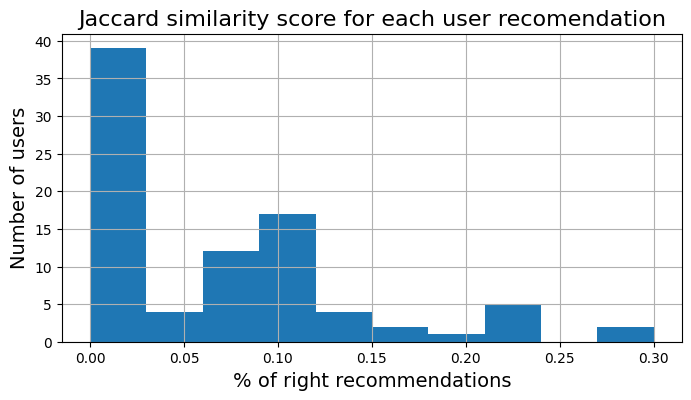

In [ ]:
# ACCURACY - JACCARDIAN SIMILARITY
print("*"*10,f"{'explicative_features'}","*"*10)
print("Mean of right suggestions: ",eval_dict.evaluation.mean())
print("Mean of users that purchased at least 1 suggestions: ",eval_dict.fl_acerto.mean())
plt.figure(figsize=(8, 4))
eval_dict['evaluation'].hist()
plt.title('Jaccard similarity score for each user recomendation', fontsize=16)
plt.xlabel('% of right recommendations', fontsize=14)
plt.ylabel('Number of users', fontsize=14)
plt.show()

In [ ]:
# SEMANTIC SIMILARITY - BERTScore
eval_dict['purchased'] = eval_dict['purchased'].apply(lambda x: ' '.join(x))
eval_dict['recommended'] = eval_dict['recommended'].apply(lambda x: ' '.join(x))
P, R, F1 = score(
    eval_dict['recommended'].to_list(),
    eval_dict['purchased'].to_list(),
    lang='en')
eval_dict['Bert_precision']=P.mean().item()
eval_dict['Bert_recall']=R.mean().item()
eval_dict['Bert_f1']=F1.mean().item()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
eval_dict['Bert_precision'].describe()

,Bert_precision
count,86.000000
mean,0.925056
std,0.000000
min,0.925056
25%,0.925056
50%,0.925056
75%,0.925056
max,0.925056


In [ ]:
eval_dict['Bert_recall'].describe()

,Bert_recall
count,86.00000
mean,0.91931
std,0.00000
min,0.91931
25%,0.91931
50%,0.91931
75%,0.91931
max,0.91931


In [ ]:
eval_dict['Bert_f1'].describe()

,Bert_f1
count,86.000000
mean,0.922161
std,0.000000
min,0.922161
25%,0.922161
50%,0.922161
75%,0.922161
max,0.922161
